In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pickle
%matplotlib inline

In [31]:
df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

In [32]:
print(len(df))
df.drop(df[df.zip == 10015].index, inplace = True)
print(len(df))
df = df.reset_index(drop = True)

3190
3179


In [33]:
years = df.year.unique()

In [34]:
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

In [35]:
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

In [36]:
arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

In [37]:
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
print(len(zip_transformation))
zip_check = pd.read_csv('other/zip_check.csv')
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True)
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
print(len(zip_check))
zip_check.reset_index(inplace = True)
for zip_value, index in zip(zip_check.zip, zip_check.index):
    if zip_value in zip_transformation.keys():
        print(zip_value)
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])
print(len(zip_transformation))

29
28
27
26
25
24
53


In [38]:
def replace_zips(df):
    # operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    # values of that row to the bigger zip then drops that row
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df            

In [39]:
for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

In [40]:
# per capita
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    for variable in index_variables:
        year_df_dict[year][variable] = copy_df[variable] / copy_df.population

In [41]:
# standard normal scaling
sns_dict = year_df_dict
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled
    

In [42]:
# pca and index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

In [43]:
sns_2015 = sns_dict[2015]

In [44]:
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
zip_shapes = zip_shapes.merge(sns_2015, on = 'zip')

In [54]:
zip_shapes['rank'] = zip_shapes.vibrancy.rank(method = 'dense')

<Figure size 1728x1296 with 0 Axes>

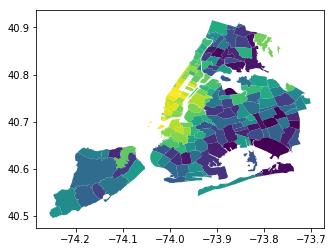

In [115]:
plt.figure(figsize = (24,18))
zip_shapes.plot(column = 'rank')
plt.savefig('vibrancy_rank.png')

In [105]:
zip_shapes.vibrancy.sort_values()

150    -0.480310
17     -0.480310
152    -0.480310
95     -0.480310
9      -0.480030
134    -0.479857
173    -0.479856
55     -0.477211
171    -0.476903
65     -0.476399
41     -0.475531
14     -0.475299
20     -0.475284
53     -0.474642
33     -0.474526
52     -0.474293
137    -0.472738
56     -0.472063
139    -0.471904
153    -0.471321
146    -0.471149
63     -0.470915
156    -0.470804
50     -0.470640
13     -0.470523
7      -0.470030
27     -0.469823
34     -0.468390
37     -0.467883
158    -0.467493
         ...    
90      0.077301
125     0.121633
108     0.129259
82      0.134771
111     0.139243
183     0.262826
102     0.384543
135     0.402032
122     0.600534
129     0.754837
140     0.918949
107     0.921154
185     0.935012
71      1.176339
119     1.197357
113     1.414191
127     1.609679
120     1.736012
85      2.178437
114     2.252277
106     3.102715
83      3.846539
105     3.873147
130     4.209770
131     4.209770
132     4.209770
133     4.209770
184     4.3701

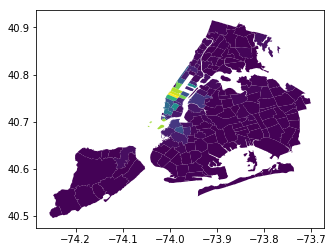

In [114]:
mmscaler = MinMaxScaler(feature_range = (0,5))
mms = zip_shapes.copy()
mms.loc[mms.vibrancy.idxmax(), 'vibrancy'] = 5
# mms.vibrancy.sort_values()
# mms['vibrancy'] = pd.DataFrame(mmscaler.fit_transform(np.array(zip_shapes.vibrancy).reshape(-1,1)))
# plt.figure(figsize = (12,9))
# ax = plt.subplot(2,2,1)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# plt.title('Vibrancy')
# plt.hist(mms.vibrancy)
mms.plot(column = 'vibrancy')
plt.savefig('hand_adjusted_vibrancy.png')

In [92]:
sns_dict[2015]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca1,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy
0,10001,2015,3.480186,2.482793,2.305868,0.528833,0.865169,1.051302,0.250196,2.096190,0.887272,2.351064,1.575452,21111,4.771827,4.771827,1.349965,3.479081,3.102715
1,10002,2015,0.007483,-0.135031,-0.054491,-0.126555,-0.069795,-0.099843,-0.111814,0.073518,-0.004237,0.151514,0.163839,81410,-0.104389,-0.104389,-0.204090,0.195110,-0.119305
2,10003,2015,4.579054,0.752356,1.207203,0.298751,0.651035,0.580170,0.239497,0.883696,0.306192,1.006898,0.853371,56024,3.778120,3.778120,0.885230,1.537697,2.252277
3,10004,2015,1.921914,0.478145,4.231880,0.964897,1.569002,1.596713,0.354815,8.935339,3.766136,7.320350,9.014852,3089,3.862438,3.862438,2.247123,14.604673,4.209770
4,10005,2015,0.504062,0.789607,0.607389,0.258721,-0.063185,0.572202,0.418299,0.036662,-0.122710,0.094402,-0.112400,7135,1.095892,1.095892,0.592377,-0.048838,0.754837
5,10006,2015,1.688338,0.021088,-0.081466,0.828913,2.178352,1.146113,1.321213,-0.227808,-0.158481,-0.244396,-0.222468,3011,0.938558,0.938558,2.733624,-0.428030,1.609679
6,10007,2015,0.648372,0.705023,0.945298,-0.060143,-0.052260,-0.015057,-0.102667,0.852328,0.175250,0.101529,-0.052422,6988,1.329238,1.329238,-0.114730,0.540056,0.600534
7,10009,2015,0.170960,-0.186934,-0.037655,-0.185895,-0.239233,-0.239373,-0.163893,-0.074011,-0.108973,0.031433,-0.070458,61347,-0.029677,-0.029677,-0.414360,-0.109144,-0.210731
8,10010,2015,0.663760,0.164334,0.161347,-0.135773,-0.172932,-0.140194,-0.133512,0.009296,0.491405,-0.092526,-0.118881,31834,0.571080,0.571080,-0.291197,0.132965,0.139243
9,10011,2015,1.558204,0.431796,0.631953,0.125814,0.288733,0.365119,0.061583,0.216330,0.045262,0.435196,0.286092,50984,1.515252,1.515252,0.421217,0.497430,0.921154


In [84]:
pca = PCA(n_components = 1)
sns_2015['pca1'] = pca.fit_transform(sns_2015[arts_providers])

In [120]:
zip_shapes.loc[zip_shapes.vibrancy.idxmax(), :]

zip                                                                   10018
geometry                  POLYGON ((-74.00170164222186 40.76138075542977...
year                                                                   2015
independent_artists                                                 9.24661
art_firms                                                           9.93882
arts_organizations                                                  11.1552
total_revenue                                                       11.7182
total_compensation                                                  9.61466
total_expenses                                                      9.61864
contributed_revenue                                                 12.3715
federal_awards                                                      8.79398
federal_dollars                                                     12.4747
state_awards                                                        9.92604
state_dollar

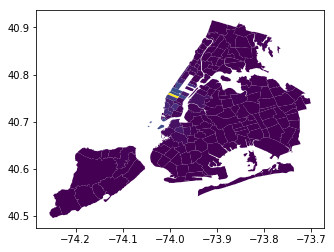

In [116]:
zip_shapes.plot(column = 'vibrancy')
plt.savefig('vibrancy_map.png')

In [87]:
sns_2015[['zip', 'independent_artists', 'art_firms', 'arts_organizations', 'pca1']]

,zip,independent_artists,art_firms,arts_organizations,pca1
0,10001,3.480186,2.482793,2.305868,4.771827
1,10002,0.007483,-0.135031,-0.054491,-0.104389
2,10003,4.579054,0.752356,1.207203,3.778120
3,10004,1.921914,0.478145,4.231880,3.862438
4,10005,0.504062,0.789607,0.607389,1.095892
5,10006,1.688338,0.021088,-0.081466,0.938558
6,10007,0.648372,0.705023,0.945298,1.329238
7,10009,0.170960,-0.186934,-0.037655,-0.029677
8,10010,0.663760,0.164334,0.161347,0.571080
9,10011,1.558204,0.431796,0.631953,1.515252


(array([162.,   7.,   5.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.52798167,  1.27751312,  3.08300791,  4.8885027 ,  6.69399749,
         8.49949228, 10.30498707, 12.11048186, 13.91597665, 15.72147144,
        17.52696622]),
 <a list of 10 Patch objects>)

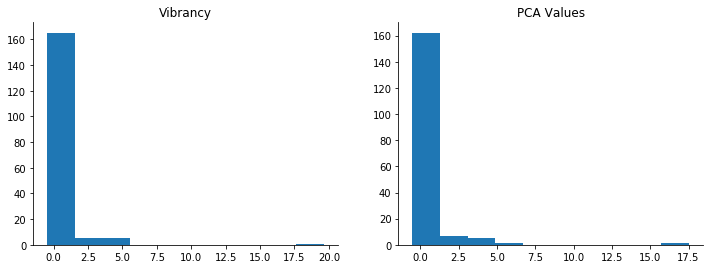

In [93]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Vibrancy')
plt.hist(sns_dict[2015].vibrancy)
ax = plt.subplot(2,2,2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('PCA Values')
plt.hist(sns_2015.pca1)

In [49]:
df_2015.sort_values('art_firms', ascending = False).head()

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population
32,10036,2015,76,11060,81,179577275,61834077.0,170072591,88008429.0,25,690000.0,116,1906580.0,24711
16,10019,2015,89,7453,92,831196376,165107122.0,504015244,431234485.0,13,610000.0,80,1577172.0,42870
19,10023,2015,74,4923,79,944887157,359202794.0,820543845,443172549.0,26,1411800.0,78,1892638.0,60998
0,10001,2015,92,3475,75,84630476,25471145.0,81483751,33636684.0,26,865000.0,136,1846234.0,21111
2,10003,2015,314,3328,116,153597493,54646287.0,138633998,87018430.0,33,1020000.0,174,2931764.0,56024


(array([ 4.,  8.,  1.,  7.,  6.,  9., 10.,  9.,  7., 11., 14., 11.,  6.,
         5.,  5.,  7., 10.,  2.,  8.,  1.,  6.,  7.,  2.,  6.,  3.,  5.,
         2.,  3.,  0.,  1.]),
 array([   184.        ,   3842.23333333,   7500.46666667,  11158.7       ,
         14816.93333333,  18475.16666667,  22133.4       ,  25791.63333333,
         29449.86666667,  33108.1       ,  36766.33333333,  40424.56666667,
         44082.8       ,  47741.03333333,  51399.26666667,  55057.5       ,
         58715.73333333,  62373.96666667,  66032.2       ,  69690.43333333,
         73348.66666667,  77006.9       ,  80665.13333333,  84323.36666667,
         87981.6       ,  91639.83333333,  95298.06666667,  98956.3       ,
        102614.53333333, 106272.76666667, 109931.        ]),
 <a list of 30 Patch objects>)

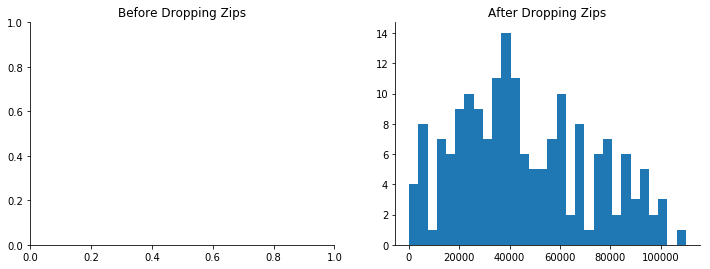

In [54]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Before Dropping Zips')
# plt.hist(df.loc[df.year == 2015, 'independent_artists'])
ax = plt.subplot(2,2,2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('After Dropping Zips')
plt.hist(df_2015.population, bins = 30)

In [53]:
df_2015.sort_values('population')

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population
165,11430,2015,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,184
5,10006,2015,7,45,1,17046930,7900625.0,12461149,16882164.0,0,0.0,0,0.0,3011
3,10004,2015,8,132,19,19802029,6073647.0,16876457,6132813.0,15,475000.0,58,1387942.0,3089
86,11109,2015,2,2,0,0,0.0,0,0.0,0,0.0,0,0.0,3523
175,11697,2015,0,0,1,4498,0.0,4163,660.0,0,0.0,0,0.0,4079
67,10464,2015,1,9,3,654926,179656.0,648113,213795.0,0,0.0,2,10000.0,4534
41,10282,2015,1,0,2,268060,0.0,280216,268060.0,1,60000.0,2,56000.0,4783
38,10069,2015,4,2,2,27750,0.0,26700,23750.0,0,0.0,0,0.0,5199
15,10018,2015,57,3231,81,343206650,55690494.0,151900462,245849182.0,25,2588268.0,132,2290730.0,5229
132,11363,2015,1,11,4,352181,0.0,339223,196223.0,0,0.0,2,26000.0,6988


In [55]:
pc_2015 = df_2015.copy()
for variable in index_variables:
    pc_2015[variable] = df_2015[variable] / df_2015.population

NameError: name 'df_2015' is not defined

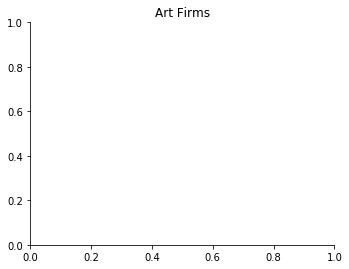

In [121]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Art Firms')
plt.hist(df_2015.art_firms)
plt.savefig('Art_Firms_Hist')

(array([158.,   9.,   5.,   2.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.36059653,  0.60012371,  1.56084395,  2.52156419,  3.48228443,
         4.44300467,  5.40372491,  6.36444514,  7.32516538,  8.28588562,
         9.24660586]),
 <a list of 10 Patch objects>)

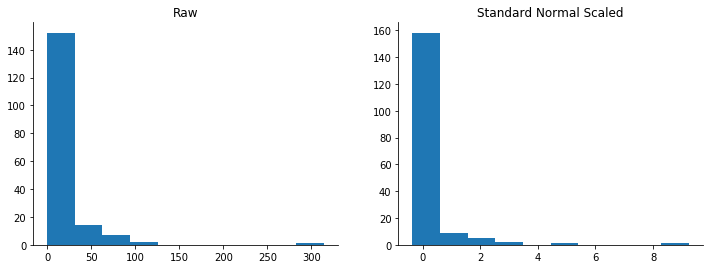

In [78]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Raw')
plt.hist(df_2015.independent_artists)
ax = plt.subplot(2,2,2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Standard Normal Scaled')
plt.hist(snscaled.independent_artists)

In [ ]:
for year in year_df_dict.keys():
    for variable in index_variables:

In [123]:
for variable in index_variables:
    df_2015[variable] = df_2015[variable] / df_2015.population

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
99,10010,2005,43,521,32,12489138,2061374.0,10350620,4313655.0,6,559485.0,52,556800.0


In [60]:
df_2015.independent_artists = (df_2015.independent_artists - df_2015.independent_artists.mean()) / df_2015.independent_artists.std()

In [61]:
df_2015.art_firms = (df_2015.art_firms - df_2015.art_firms.mean()) / df_2015.art_firms.std()
df_2015.arts_organizations = (df_2015.arts_organizations - df_2015.arts_organizations.mean()) / df_2015.arts_organizations.std()

In [62]:
df[['zip', 'total_revenue']].sort_values(by = 'total_revenue', ascending = False)

,zip,total_revenue
252,10023,944887157
246,10023,876708491
245,10023,865443903
244,10023,835564883
208,10019,830719742
247,10023,822526785
248,10023,813812807
251,10023,780803237
243,10023,763124566
250,10023,754344669


In [74]:
df[(df.year==2015) & (df.zip == 10015)]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
164,10015,2015,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0


In [64]:
df_2015[df_2015.zip == 11430]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population
194,11430,2015,-0.120039,-0.088494,-0.124335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184


In [65]:
len(df[df.year == 2015].zip.unique())

290

In [66]:
df_2015[['zip', 'population', 'total_revenue']].sort_values(by = 'total_revenue', ascending = True)

,zip,population,total_revenue
104,10475,40931,0.000000
50,10162,1685,0.000000
58,10173,2,0.000000
177,11411,18556,0.000000
61,10199,9,0.000000
166,11369,38615,0.000000
112,11109,3523,0.000000
182,11416,24861,0.000000
185,11419,47211,0.000000
76,10310,24962,0.000000


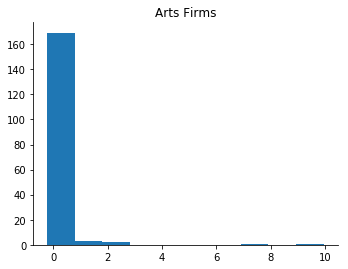

In [125]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Arts Firms')
plt.hist(sns_dict[2015]['art_firms'])
plt.savefig('Art Firms Per Capita Hist')

In [128]:
sns_dict[2015].sort_values(by = 'art_firms')

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy
175,11697,2015,-0.360597,-0.224739,-0.145926,-0.198841,-0.252663,-0.261103,-0.174945,-0.227808,-0.158481,-0.244396,-0.222468,4079,-0.421417,-0.443960,-0.428030,-0.432222
157,11420,2015,-0.360597,-0.224739,-0.260806,-0.198099,-0.252663,-0.259755,-0.173880,-0.227808,-0.158481,-0.244396,-0.222468,44354,-0.488781,-0.442384,-0.428030,-0.461827
41,10282,2015,-0.176333,-0.224739,-0.017692,-0.188865,-0.252663,-0.241524,-0.160033,0.166713,0.161683,-0.075930,0.018234,4783,-0.239883,-0.421747,0.132192,-0.284514
43,10302,2015,-0.268252,-0.224739,-0.288823,-0.198972,-0.252663,-0.261446,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,19088,-0.451917,-0.444219,-0.428030,-0.446065
55,10452,2015,-0.360597,-0.224739,-0.298153,-0.197444,-0.250095,-0.258381,-0.172813,-0.202772,-0.155095,-0.201633,-0.196010,75371,-0.510680,-0.439554,-0.378585,-0.465464
58,10455,2015,-0.338377,-0.224739,-0.308969,-0.198100,-0.251962,-0.259927,-0.174182,-0.180235,-0.145612,-0.244396,-0.222468,39665,-0.504200,-0.442269,-0.397822,-0.465693
60,10457,2015,-0.360597,-0.224739,-0.317143,-0.198602,-0.252663,-0.260455,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,70496,-0.521816,-0.443536,-0.428030,-0.477211
159,11422,2015,-0.331629,-0.224739,-0.278929,-0.198584,-0.252663,-0.260541,-0.174727,-0.227808,-0.158481,-0.244396,-0.222468,30425,-0.482691,-0.443441,-0.428030,-0.459562
74,10471,2015,-0.322147,-0.224739,-0.165961,-0.197549,-0.252663,-0.258882,-0.173622,-0.145486,-0.136212,-0.103785,-0.153587,22922,-0.410976,-0.441541,-0.269256,-0.410558
76,10473,2015,-0.345536,-0.224739,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,58519,-0.519290,-0.444256,-0.428030,-0.476399


In [16]:
pca = PCA(n_components = 1)

In [17]:
component1 = pca.fit_transform(df_2015[['independent_artists', 'art_firms', 'arts_organizations']])

KeyError: ('independent_artists', 'art_firms', 'arts_organizations')

In [12]:
df_2015[['independent_artists', 'art_firms', 'arts_organizations']]

,independent_artists,art_firms,arts_organizations
0,-0.107480,-0.019358,-0.082952
1,-0.118836,-0.086204,-0.120044
2,-0.103894,-0.063554,-0.100227
3,-0.112579,-0.070553,-0.052718
4,-0.117213,-0.062721,-0.111280
5,-0.113342,-0.082219,-0.120468
6,-0.116741,-0.064763,-0.104340
7,-0.118301,-0.087529,-0.119780
8,-0.116691,-0.078563,-0.116654
9,-0.113767,-0.071736,-0.109262


In [133]:
test_geo = gpd.read_file('zip_2015.geojson')

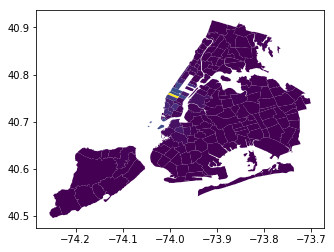

In [134]:
test_geo.plot(column = 'vibrancy')

In [135]:
test_geo

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank,geometry
0,11372,2015,-0.294466,-0.217827,-0.216414,-0.197251,-0.252663,-0.258483,-0.173327,-0.171172,-0.146990,-0.208120,-0.206425,66636,-0.420657,-0.441045,-0.367298,-0.424496,99.0,POLYGON ((-73.86942457284175 40.74915687096787...
1,11004,2015,-0.360597,-0.189532,-0.221881,-0.198517,-0.252663,-0.260965,-0.174219,-0.227808,-0.158481,-0.186907,-0.190199,14016,-0.445943,-0.443368,-0.382414,-0.438432,88.0,POLYGON ((-73.71068374074007 40.75004039450917...
2,11426,2015,-0.360597,-0.224739,-0.201231,-0.197336,-0.252663,-0.258757,-0.173077,-0.227808,-0.158481,-0.244396,-0.222468,17590,-0.453847,-0.441101,-0.428030,-0.445530,78.0,POLYGON ((-73.72270447144122 40.75373371438336...
3,11365,2015,-0.339738,-0.211503,-0.222392,-0.195621,-0.247874,-0.254279,-0.172958,-0.227808,-0.158481,-0.244396,-0.222468,42252,-0.446694,-0.435538,-0.428030,-0.439807,86.0,POLYGON ((-73.81088634744755 40.72717187575918...
4,11373,2015,-0.343113,-0.224413,-0.283543,-0.197870,-0.252169,-0.259503,-0.173610,-0.227808,-0.158481,-0.244396,-0.222468,100820,-0.491838,-0.441761,-0.428030,-0.462923,37.0,POLYGON ((-73.88722098467157 40.72752618766134...
5,11375,2015,-0.270838,-0.209184,-0.262948,-0.198167,-0.252156,-0.259805,-0.174779,-0.227808,-0.158481,-0.244396,-0.222468,68733,-0.429395,-0.442633,-0.428030,-0.435216,91.0,"POLYGON ((-73.8562474640478 40.7367227854824, ..."
6,11427,2015,-0.323241,-0.221950,-0.264819,-0.199040,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,23593,-0.467990,-0.444256,-0.428030,-0.453314,62.0,POLYGON ((-73.74168681424477 40.73682340115314...
7,11374,2015,-0.360597,-0.219835,-0.293654,-0.198988,-0.252663,-0.261344,-0.174911,-0.227808,-0.158481,-0.244396,-0.222468,43600,-0.505255,-0.444138,-0.428030,-0.470030,23.0,POLYGON ((-73.86451198956482 40.73407164841783...
8,11366,2015,-0.360597,-0.195566,-0.272878,-0.198845,-0.252663,-0.261184,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,13532,-0.479277,-0.444024,-0.428030,-0.458289,53.0,POLYGON ((-73.77010678596534 40.73177920848852...
9,11423,2015,-0.360597,-0.223642,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,29987,-0.527358,-0.444256,-0.428030,-0.480030,2.0,POLYGON ((-73.77010678596534 40.73177920848852...


In [131]:
zip_shapes

,zip,geometry,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,2015,-0.294466,-0.217827,-0.216414,-0.197251,-0.252663,-0.258483,-0.173327,-0.171172,-0.146990,-0.208120,-0.206425,66636,-0.420657,-0.441045,-0.367298,-0.424496,99.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,2015,-0.360597,-0.189532,-0.221881,-0.198517,-0.252663,-0.260965,-0.174219,-0.227808,-0.158481,-0.186907,-0.190199,14016,-0.445943,-0.443368,-0.382414,-0.438432,88.0
2,11426,POLYGON ((-73.72270447144122 40.75373371438336...,2015,-0.360597,-0.224739,-0.201231,-0.197336,-0.252663,-0.258757,-0.173077,-0.227808,-0.158481,-0.244396,-0.222468,17590,-0.453847,-0.441101,-0.428030,-0.445530,78.0
3,11365,POLYGON ((-73.81088634744755 40.72717187575918...,2015,-0.339738,-0.211503,-0.222392,-0.195621,-0.247874,-0.254279,-0.172958,-0.227808,-0.158481,-0.244396,-0.222468,42252,-0.446694,-0.435538,-0.428030,-0.439807,86.0
4,11373,POLYGON ((-73.88722098467157 40.72752618766134...,2015,-0.343113,-0.224413,-0.283543,-0.197870,-0.252169,-0.259503,-0.173610,-0.227808,-0.158481,-0.244396,-0.222468,100820,-0.491838,-0.441761,-0.428030,-0.462923,37.0
5,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ...",2015,-0.270838,-0.209184,-0.262948,-0.198167,-0.252156,-0.259805,-0.174779,-0.227808,-0.158481,-0.244396,-0.222468,68733,-0.429395,-0.442633,-0.428030,-0.435216,91.0
6,11427,POLYGON ((-73.74168681424477 40.73682340115314...,2015,-0.323241,-0.221950,-0.264819,-0.199040,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,23593,-0.467990,-0.444256,-0.428030,-0.453314,62.0
7,11374,POLYGON ((-73.86451198956482 40.73407164841783...,2015,-0.360597,-0.219835,-0.293654,-0.198988,-0.252663,-0.261344,-0.174911,-0.227808,-0.158481,-0.244396,-0.222468,43600,-0.505255,-0.444138,-0.428030,-0.470030,23.0
8,11366,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.195566,-0.272878,-0.198845,-0.252663,-0.261184,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,13532,-0.479277,-0.444024,-0.428030,-0.458289,53.0
9,11423,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.223642,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,29987,-0.527358,-0.444256,-0.428030,-0.480030,2.0


In [136]:
test_2010 = gpd.read_file('zip_2010.geojson')

In [140]:
test_2010

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank,geometry
0,11372,2010,-0.317538,-0.222253,-0.212608,-0.240023,-0.227015,-0.244129,-0.258363,-0.232053,-0.259793,-0.181527,-0.199307,66636,-0.436212,-0.484781,-0.436498,-0.458097,90.0,POLYGON ((-73.86942457284175 40.74915687096787...
1,11004,2010,-0.347687,-0.175051,-0.294746,-0.246244,-0.231830,-0.248383,-0.266256,-0.232053,-0.259793,-0.232341,-0.215810,14016,-0.476515,-0.496371,-0.469940,-0.484793,37.0,POLYGON ((-73.71068374074007 40.75004039450917...
2,11426,2010,-0.347687,-0.232931,-0.250294,-0.244898,-0.231830,-0.247145,-0.263357,-0.232053,-0.259793,-0.232341,-0.215810,17590,-0.482159,-0.493628,-0.469940,-0.486098,34.0,POLYGON ((-73.72270447144122 40.75373371438336...
3,11365,2010,-0.323913,-0.228075,-0.202217,-0.240594,-0.231830,-0.243258,-0.260053,-0.232053,-0.259793,-0.232341,-0.215810,42252,-0.437147,-0.487875,-0.469940,-0.463254,84.0,POLYGON ((-73.81088634744755 40.72717187575918...
4,11373,2010,-0.347687,-0.235777,-0.286990,-0.246129,-0.231830,-0.248208,-0.266233,-0.232053,-0.259793,-0.232341,-0.215810,100820,-0.505155,-0.496214,-0.469940,-0.497610,8.0,POLYGON ((-73.88722098467157 40.72752618766134...
5,11375,2010,-0.260000,-0.217931,-0.249242,-0.242579,-0.231830,-0.246173,-0.265567,-0.232053,-0.259793,-0.232341,-0.215810,68733,-0.420721,-0.493085,-0.469940,-0.458207,89.0,"POLYGON ((-73.8562474640478 40.7367227854824, ..."
6,11427,2010,-0.305111,-0.233655,-0.261604,-0.245795,-0.231830,-0.247389,-0.265748,-0.232053,-0.259793,-0.232341,-0.215810,23593,-0.463609,-0.495394,-0.469940,-0.478545,61.0,POLYGON ((-73.74168681424477 40.73682340115314...
7,11374,2010,-0.324648,-0.224294,-0.276812,-0.245699,-0.231830,-0.248188,-0.265083,-0.232053,-0.259793,-0.232341,-0.215810,43600,-0.479107,-0.495414,-0.469940,-0.485529,35.0,POLYGON ((-73.86451198956482 40.73407164841783...
8,11366,2010,-0.273456,-0.191379,-0.236964,-0.243883,-0.231830,-0.248119,-0.261176,-0.232053,-0.259793,-0.232341,-0.215810,13532,-0.407120,-0.492519,-0.469940,-0.451832,96.0,POLYGON ((-73.77010678596534 40.73177920848852...
9,11423,2010,-0.347687,-0.234108,-0.294746,-0.246244,-0.231830,-0.248383,-0.266256,-0.232053,-0.259793,-0.232341,-0.215810,29987,-0.508774,-0.496371,-0.469940,-0.499309,4.0,POLYGON ((-73.77010678596534 40.73177920848852...


In [11]:
raw = pd.read_csv('index_raw.csv')
clean = pd.read_csv('index_clean_raw.csv')

In [12]:
len(raw.index)

2937

In [5]:
len(clean.index)

1885

In [13]:
sum(raw['year'] == 2005)

267

In [7]:
sum(clean['year'] == 2005)

166

In [14]:
raw_zips = raw['zip'].unique()
clean_zips = clean['zip'].unique()

In [19]:
raw_zips[list(x not in clean_zips for x in raw_zips)]

array([10008, 10015, 10020, 10041, 10045, 10048, 10055, 10060, 10090,
       10095, 10098, 10099, 10101, 10103, 10104, 10105, 10106, 10107,
       10108, 10110, 10111, 10112, 10113, 10115, 10116, 10118, 10119,
       10120, 10121, 10122, 10123, 10125, 10129, 10150, 10151, 10152,
       10153, 10154, 10155, 10156, 10158, 10159, 10161, 10162, 10163,
       10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173,
       10174, 10175, 10176, 10177, 10178, 10185, 10199, 10270, 10271,
       10272, 10276, 10278, 10279, 10286, 10311, 11202, 11239, 11241,
       11242, 11243, 11245, 11247, 11252, 11256, 11351, 11352, 11359,
       11371, 11424, 11430, 11439, 11695])

In [20]:
raw[raw['zip'] == 10165]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
957,10165,2005,6,78,4,2991775,271936.0,2598640,1447202.0,0,0.0,2,5000.0
958,10165,2006,7,53,4,636100,35000.0,448762,199495.0,0,0.0,0,0.0
959,10165,2007,8,61,4,484206,35000.0,463810,149004.0,0,0.0,0,0.0
960,10165,2008,5,33,4,296773,50000.0,389506,106886.0,0,0.0,0,0.0
961,10165,2009,2,42,2,134859,0.0,139893,43075.0,0,0.0,0,0.0
962,10165,2010,3,54,2,203225,0.0,183889,63990.0,0,0.0,0,0.0
963,10165,2011,4,26,2,220208,0.0,171579,16720.0,0,0.0,0,0.0
964,10165,2012,6,21,1,111958,0.0,70378,0.0,0,0.0,0,0.0
965,10165,2013,4,12,1,72240,0.0,100884,0.0,0,0.0,0,0.0
966,10165,2014,4,12,1,86687,0.0,139033,0.0,0,0.0,0,0.0


In [22]:
raw[raw['zip'] == 10017]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
176,10017,2005,58,740,35,43912566,7833832.0,38186815,21094337.0,3,48000.0,20,136244.0
177,10017,2006,56,1150,41,61519072,8751494.0,34057525,15711762.0,3,80000.0,22,198300.0
178,10017,2007,31,578,37,25210781,5717482.0,23194096,14425615.0,3,85000.0,40,339850.0
179,10017,2008,32,772,36,23910835,5748536.0,22421081,11972409.0,4,42500.0,24,253600.0
180,10017,2009,33,769,33,27220983,5908863.0,19941966,46229997.0,8,217500.0,20,179448.0
181,10017,2010,36,867,43,63538585,5398782.0,62144619,11486225.0,4,85000.0,34,296242.0
182,10017,2011,32,788,27,30288526,5704599.0,22283113,23433468.0,5,118000.0,30,295742.0
183,10017,2012,45,1407,29,26462403,5973374.0,23322357,19917520.0,4,155000.0,26,218000.0
184,10017,2013,40,1056,29,185544047,65080252.0,168649701,69177654.0,3,55000.0,26,233392.0
185,10017,2014,45,713,33,225382808,71507649.0,195318855,92672606.0,3,115000.0,4,14200.0


In [23]:
clean[clean['zip'] == 10017]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
154,10017,2005,71,870,56,93433847,8411220,77380169,32351544,4,58000.0,30,249144.0
155,10017,2006,72,1287,68,114252701,9061790,70093161,23812326,4,100000.0,30,300500.0
156,10017,2007,47,715,61,131481972,5877303,69149727,44369063,4,115000.0,46,419960.0
157,10017,2008,48,893,80,154293205,6283753,96485004,16831585,4,42500.0,26,288200.0
158,10017,2009,50,922,80,185218789,6138910,115250923,50915929,9,247500.0,20,179448.0
159,10017,2010,53,1009,67,88158584,5398782,70510207,13163161,4,85000.0,34,296242.0
160,10017,2011,49,905,52,41537641,5750200,29951682,25059520,5,118000.0,32,370312.0
161,10017,2012,67,1528,50,35945427,5973374,30789005,21166238,4,155000.0,28,239800.0
162,10017,2013,58,1207,47,188331549,65080252,170817021,70202868,4,80000.0,28,255192.0
163,10017,2014,75,823,64,244438286,71757210,204015343,95932882,4,151000.0,4,14200.0


In [29]:
for zipcode in clean['zip'].unique():
    if len(clean[clean['zip'] == zipcode].index) != 11:
        print(zipcode)

10037
10281
10308
10454
10457
10466
10473
10475
11005
11109
11249
11369
11411
11419
11426
11429
11433
11436
11692
11693
11697


In [38]:
clean[clean['zip'] == 10454]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
651,10454,2005,0,4,0,0,0,0,0,0,0.0,0,0.0
652,10454,2006,0,2,0,0,0,0,0,0,0.0,0,0.0
653,10454,2008,0,2,1,292669,178248,288431,7367,0,0.0,0,0.0
654,10454,2009,0,9,2,257791,97009,244954,115393,0,0.0,0,0.0
655,10454,2010,1,9,2,208187,95307,241378,88942,0,0.0,0,0.0
656,10454,2011,1,2,2,208187,95307,241378,88942,1,75000.0,0,0.0
657,10454,2012,0,4,0,0,0,0,0,0,0.0,2,18000.0
658,10454,2013,0,4,2,291759,114651,290794,162157,0,0.0,2,18000.0
659,10454,2014,0,6,3,286831,105298,304683,174517,0,0.0,0,0.0
660,10454,2015,0,6,3,330282,64816,294388,288313,0,0.0,4,40000.0


In [39]:
zip_2007 = gpd.read_file('geojsons/zip_2007.geojson')

In [40]:
zip_2007[zip_2007['zip'] == 10454]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank,geometry
72,10454,2007,-0.352215,-0.228273,-0.298793,-0.254036,-0.22697,-0.241108,-0.283569,-0.205638,-0.196741,-0.209374,-0.192323,37337,-0.511225,-0.502727,-0.401924,-0.496471,1.0,"POLYGON ((-73.9317564471804 40.80793457778949,..."


In [61]:
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode

In [63]:
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])
zip_transformation

{10165: 10017,
 10170: 10017,
 10173: 10017,
 10167: 10017,
 10174: 10017,
 10168: 10017,
 10169: 10017,
 10177: 10017,
 10172: 10017,
 10171: 10017,
 10110: 10036,
 10020: 10019,
 10112: 10019,
 10103: 10019,
 10162: 10075,
 10153: 10022,
 10152: 10022,
 10154: 10022,
 10199: 10001,
 10119: 10001,
 10278: 10007,
 10279: 10007,
 10271: 10005,
 10111: 10019,
 10115: 10027,
 10311: 10314,
 11351: 11356,
 11359: 11360,
 11371: 11369,
 10041: 10004,
 10048: 10007,
 10104: 10019,
 10105: 10019,
 10106: 10019,
 10107: 10019,
 10118: 10001,
 10121: 10001,
 10122: 10001,
 10123: 10018,
 10151: 10022,
 10155: 10022,
 10158: 10016,
 10166: 10017,
 10175: 10036,
 10176: 10036,
 10178: 10017,
 10286: 10007,
 10008: 10007,
 10101: 10019,
 10108: 10036,
 10113: 10011,
 10116: 10001,
 10125: 10022,
 10129: 10018,
 10150: 10022,
 10156: 10016,
 10159: 10010,
 10163: 10017,
 10185: 10020,
 10272: 10038,
 10276: 10003,
 11202: 11201,
 11242: 11201,
 11243: 11217,
 11245: 11201,
 11247: 11216,
 11352: 11

In [65]:
df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

In [66]:
test_string = 'nccs.core2014pc.csv'
test_string[-10:-6]

'2014'

In [71]:
test_irs_df = pd.read_csv('/home/steve/Documents/irs/other/coreco.core2013co.csv')

/home/steve/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (128,144,158) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
def get_ny(dataframe):
    NYZIPS = [10453.0, 10457.0, 10460.0, 10458.0, 10467.0, 10468.0, 10451.0, 10452.0, 10456.0, 10454.0,
10455.0, 10459.0, 10474.0, 10463.0, 10471.0, 10466.0, 10469.0, 10470.0, 10475.0, 10461.0,
10462.0, 10464.0, 10465.0, 10472.0, 10473.0, 11212.0, 11213.0, 11216.0, 11233.0, 11238.0,
11209.0, 11214.0, 11228.0, 11204.0, 11218.0, 11219.0, 11230.0, 11234.0, 11236.0, 11239.0,
11223.0, 11224.0, 11229.0, 11235.0, 11201.0, 11205.0, 11215.0, 11217.0, 11231.0, 11203.0,
11210.0, 11225.0, 11226.0, 11207.0, 11208.0, 11211.0, 11222.0, 11220.0, 11232.0, 11206.0,
11221.0, 11237.0, 10026.0, 10027.0, 10030.0, 10037.0, 10039.0, 10001.0, 10011.0, 10018.0,
10019.0, 10020.0, 10036.0, 10029.0, 10035.0, 10010.0, 10016.0, 10017.0, 10022.0, 10012.0,
10013.0, 10014.0, 10004.0, 10005.0, 10006.0, 10007.0, 10038.0, 10280.0, 10002.0, 10003.0,
10009.0, 10021.0, 10028.0, 10044.0, 10065.0, 10075.0, 10128.0, 10023.0, 10024.0, 10025.0,
10031.0, 10032.0, 10033.0, 10034.0, 10040.0, 11361.0, 11362.0, 11363.0, 11364.0, 11354.0,
11355.0, 11356.0, 11357.0, 11358.0, 11359.0, 11360.0, 11365.0, 11366.0, 11367.0, 11412.0,
11423.0, 11432.0, 11433.0, 11434.0, 11435.0, 11436.0, 11101.0, 11102.0, 11103.0, 11104.0,
11105.0, 11106.0, 11374.0, 11375.0, 11379.0, 11385.0, 11691.0, 11692.0, 11693.0, 11694.0,
11695.0, 11697.0, 11004.0, 11005.0, 11411.0, 11413.0, 11422.0, 11426.0, 11427.0, 11428.0,
11429.0, 11414.0, 11415.0, 11416.0, 11417.0, 11418.0, 11419.0, 11420.0, 11421.0, 11368.0,
11369.0, 11370.0, 11372.0, 11373.0, 11377.0, 11378.0, 10302.0, 10303.0, 10310.0, 10306.0,
10307.0, 10308.0, 10309.0, 10312.0, 10301.0, 10304.0, 10305.0, 10314.0, 10119.0, 11249.0,
10008.0, 10279.0, 10271.0, 10041.0, 10163.0, 10107.0, 10108.0, 10113.0, 10123.0, 11351.0,
10115.0, 10276.0, 10150.0, 11439.0, 11451.0, 11202.0, 10170.0, 11424.0, 10185.0, 10122.0,
11690.0, 11242.0, 11352.0, 10116.0, 10167.0, 10282.0, 11247.0, 10278.0, 10121.0, 10155.0,
10168.0, 10281.0, 10118.0, 10110.0, 10158.0, 10159.0, 10165.0, 11241.0, 10156.0, 10178.0,
10120.0, 10105.0, 10104.0, 10175.0, 10101.0, 10153.0, 10268.0, 10173.0, 10111.0, 10311.0,
10166.0, 10069.0, 10272.0, 10112.0, 10176.0, 10162.0, 10174.0, 10177.0, 10151.0, 11430.0,
11386.0, 10106.0, 10169.0, 10154.0, 11109.0, 11380.0, 10129.0, 10103.0, 10045.0, 10171.0,
10286.0, 11371.0, 11120.0, 11431.0, 10274.0, 11243.0, 11240.0, 10015.0, 10048.0, 10249.0,
10285.0, 10152.0, 10270.0, 10102.0, 10043.0, 10172.0, 10109.0, 10081.0, 11252.0, 10055.0,
10313.0, 11251.0, 10125.0, 10133.0, 10117.0, 10138.0, 10164.0, 10292.0, 10260.0, 10072.0,
10080.0, 10179.0, 10021, 10065, 11219, 10022, 10003, 10028, 10122,
11217, 10017, 11361, 10013, 10004, 10005, 10001, 10168, 10016, 11210,
10031, 11223, 10036, 10018, 11211, 10024, 10019, 10119, 11204, 10023,
10128, 11106, 11234, 11120, 11375, 10008, 10274, 11694, 10165, 10025,
11249, 10173, 10158, 10471, 10309, 10312, 11427, 10014, 10010, 11230,
10170, 11205, 11215, 10177, 11201, 10020, 11238, 11231, 10111, 10461,
10150, 10306, 11214, 10007, 11224, 10118, 10153, 10110, 10012, 10163,
11218, 11373, 10107, 11367, 11220, 10032, 10075, 10115, 11235, 10011,
11415, 10027, 10463, 10002, 10026, 11101, 10120, 10103, 10055, 10039,
11245.0, 11256.0, 11425.0, 10046.0, 10199.0, 10123, 10009, 11378, 11229, 10006,
10038, 10155, 11364, 11418, 10279, 10470, 10468, 11241, 10310, 10467,
11434, 11372, 10314, 10272, 10048, 10116, 11228, 10308, 10462, 10307,
10304, 11430, 11358, 11209, 11374, 11354, 11377, 11421, 10286, 11232,
11245, 10469, 10176, 11385, 10044, 11102, 10459, 11435, 10281, 10034,
10130.0, 11381.0, 10114.0]
    NYFIPS = [36005.0, 36047.0, 36061.0, 36081.0, 36085.0, 36005, 36047, 36061, 36081, 36085,
             '36005', '36047', '36061', '36081', '36085' ]
    # need to come up with some tests for when this fails
    # one possible test is checking that the ZIP5 and FIP match
    try:
        new_df = dataframe[dataframe.ZIP5.isin(NYZIPS) | dataframe.FIPS.isin(NYFIPS)]
    except AttributeError:
        new_df = dataframe[dataframe.Zip5.isin(NYZIPS) | dataframe.Fips.isin(NYFIPS)]
    return new_df

In [73]:
test_irs_df = get_ny(test_irs_df)

In [74]:
len(test_irs_df.index)

2405

In [78]:
test_irs_df['ZIP5']

6         11209.0
92        11432.0
136       11354.0
148       11368.0
154       10036.0
155       10013.0
156       10023.0
157       10465.0
160       10465.0
162       10013.0
163       10041.0
166       10016.0
169       10001.0
170       10004.0
172       10017.0
175       10016.0
176       10004.0
178       10036.0
181       11241.0
182       10004.0
183       10003.0
184       10029.0
185       10004.0
187       10075.0
188       10018.0
189       10010.0
190       10003.0
192       10017.0
193       10017.0
194       10012.0
           ...   
136566    10036.0
136641    10170.0
136674    11249.0
136787    11226.0
136816    10023.0
136974    10018.0
137128    11354.0
137129    11378.0
137165    10036.0
137256    10013.0
137295    11377.0
137394    10001.0
137404    11209.0
137602    10014.0
137625    11214.0
137634    10017.0
137675    11435.0
137679    10018.0
137691    10163.0
137851    11238.0
137891    11209.0
137925    11360.0
138071    10001.0
138144    10016.0
138549    

In [30]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

year_df_dict_copy = year_df_dict.copy()
for year in year_df_dict_copy.keys():
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population'], axis = 'columns')
    year_df_dict_copy[year] = year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})

for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    for variable in index_variables:
        year_df_dict[year][variable] = copy_df[variable] / copy_df.population 

# standard normal scaling
sns_dict = year_df_dict.copy()
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled

# doing the pca and calculating the index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

# taking all this info and adding it to the GeoJSON with the zips
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
geo_dict = sns_dict.copy()
for year in years:
    geo_dict[year] = zip_shapes.merge(sns_dict[year], on = 'zip').merge(year_df_dict_copy[year], on = 'zip')
    geo_dict[year]['rank'] = geo_dict[year].vibrancy.rank(method = 'dense')

In [25]:
for year in years:
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population'], axis = 'columns')
    year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})
    geo_dict[year] = geo_dict[year].merge(year_df_dict_copy[year], on = 'zip')


In [22]:
geo_dict[2015]

,zip,geometry,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,2015,-0.294466,-0.217827,-0.216414,-0.197251,-0.252663,-0.258483,-0.173327,-0.159967,-0.141358,-0.196471,-0.197590,66636,-0.420657,-0.441045,-0.348523,-0.422618,99.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,2015,-0.360597,-0.189532,-0.221881,-0.198517,-0.252663,-0.260965,-0.174219,-0.217320,-0.152873,-0.174918,-0.181250,14016,-0.445943,-0.443368,-0.363775,-0.436568,88.0
2,11426,POLYGON ((-73.72270447144122 40.75373371438336...,2015,-0.360597,-0.224739,-0.201231,-0.197336,-0.252663,-0.258757,-0.173077,-0.217320,-0.152873,-0.233328,-0.213746,17590,-0.453847,-0.441101,-0.409974,-0.443724,78.0
3,11365,POLYGON ((-73.81088634744755 40.72717187575918...,2015,-0.339738,-0.211503,-0.222392,-0.195621,-0.247874,-0.254279,-0.172958,-0.217320,-0.152873,-0.233328,-0.213746,42252,-0.446694,-0.435538,-0.409974,-0.438002,86.0
4,11373,POLYGON ((-73.88722098467157 40.72752618766134...,2015,-0.343113,-0.224413,-0.283543,-0.197870,-0.252169,-0.259503,-0.173610,-0.217320,-0.152873,-0.233328,-0.213746,100820,-0.491838,-0.441761,-0.409974,-0.461117,37.0
5,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ...",2015,-0.270838,-0.209184,-0.262948,-0.198167,-0.252156,-0.259805,-0.174779,-0.217320,-0.152873,-0.233328,-0.213746,68733,-0.429395,-0.442633,-0.409974,-0.433410,91.0
6,11427,POLYGON ((-73.74168681424477 40.73682340115314...,2015,-0.323241,-0.221950,-0.264819,-0.199040,-0.252663,-0.261450,-0.174989,-0.217320,-0.152873,-0.233328,-0.213746,23593,-0.467990,-0.444256,-0.409974,-0.451508,62.0
7,11374,POLYGON ((-73.86451198956482 40.73407164841783...,2015,-0.360597,-0.219835,-0.293654,-0.198988,-0.252663,-0.261344,-0.174911,-0.217320,-0.152873,-0.233328,-0.213746,43600,-0.505255,-0.444138,-0.409974,-0.468224,23.0
8,11366,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.195566,-0.272878,-0.198845,-0.252663,-0.261184,-0.174989,-0.217320,-0.152873,-0.233328,-0.213746,13532,-0.479277,-0.444024,-0.409974,-0.456483,53.0
9,11423,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.223642,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,-0.217320,-0.152873,-0.233328,-0.213746,29987,-0.527358,-0.444256,-0.409974,-0.478224,2.0


In [23]:
geo_dict[2009]

,zip,geometry,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,2009,-0.339149,-0.229965,-0.226584,-0.236721,-0.238024,-0.243974,-0.276166,-0.185305,-0.209318,-0.161541,-0.200779,66636,-0.461281,-0.497206,-0.378505,-0.469170,83.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,2009,-0.354444,-0.187934,-0.298425,-0.241484,-0.240274,-0.248309,-0.280457,-0.205373,-0.214180,-0.209448,-0.218838,14016,-0.489444,-0.505021,-0.423937,-0.489903,39.0
2,11426,POLYGON ((-73.72270447144122 40.75373371438336...,2009,-0.354444,-0.238333,-0.253066,-0.239598,-0.240274,-0.246963,-0.276664,-0.205373,-0.214180,-0.209448,-0.218838,17590,-0.490509,-0.501525,-0.423937,-0.488809,43.0
3,11365,POLYGON ((-73.81088634744755 40.72717187575918...,2009,-0.330322,-0.233510,-0.222891,-0.234887,-0.238306,-0.243566,-0.274406,-0.205373,-0.214180,-0.209448,-0.218838,42252,-0.455789,-0.495353,-0.423937,-0.470407,80.0
4,11373,POLYGON ((-73.88722098467157 40.72752618766134...,2009,-0.354444,-0.241161,-0.282597,-0.241190,-0.240274,-0.248107,-0.279868,-0.205373,-0.214180,-0.209448,-0.218838,100820,-0.509350,-0.504481,-0.423937,-0.498618,14.0
5,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ...",2009,-0.295130,-0.223433,-0.251992,-0.239024,-0.239854,-0.246387,-0.280161,-0.205373,-0.214180,-0.209448,-0.218838,68733,-0.446287,-0.502465,-0.423937,-0.469332,81.0
6,11427,POLYGON ((-73.74168681424477 40.73682340115314...,2009,-0.311244,-0.239053,-0.298425,-0.241484,-0.240274,-0.248309,-0.280457,-0.205373,-0.214180,-0.209448,-0.218838,23593,-0.491661,-0.505021,-0.423937,-0.490900,36.0
7,11374,POLYGON ((-73.86451198956482 40.73407164841783...,2009,-0.331067,-0.228043,-0.280125,-0.241125,-0.240041,-0.247887,-0.280114,-0.205373,-0.214180,-0.209448,-0.218838,43600,-0.486751,-0.504343,-0.423937,-0.488386,44.0
8,11366,POLYGON ((-73.77010678596534 40.73177920848852...,2009,-0.203808,-0.197056,-0.298425,-0.241484,-0.240274,-0.248309,-0.280457,-0.205373,-0.214180,-0.209448,-0.218838,13532,-0.404474,-0.505021,-0.423937,-0.451666,97.0
9,11423,POLYGON ((-73.77010678596534 40.73177920848852...,2009,-0.354444,-0.239502,-0.298425,-0.241484,-0.240274,-0.248309,-0.280457,-0.205373,-0.214180,-0.209448,-0.218838,29987,-0.517709,-0.505021,-0.423937,-0.502622,5.0


In [32]:
geo_dict[2015]

,zip,geometry,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,...,arts_organizations_raw,total_revenue_raw,total_compensation_raw,total_expenses_raw,contributed_revenue_raw,federal_awards_raw,federal_dollars_raw,state_awards_raw,state_dollars_raw,rank
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,2015,-0.294466,-0.217827,-0.216414,-0.197251,-0.252663,-0.258483,-0.173327,...,10,656882,0.0,581312,414818.0,2,30000.0,6,52000.0,99.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,2015,-0.360597,-0.189532,-0.221881,-0.198517,-0.252663,-0.260965,-0.174219,...,2,40452,0.0,20005,40452.0,0,0.0,2,22000.0,88.0
2,11426,POLYGON ((-73.72270447144122 40.75373371438336...,2015,-0.360597,-0.224739,-0.201231,-0.197336,-0.252663,-0.258757,-0.173077,...,3,165112,0.0,139291,126034.0,0,0.0,0,0.0,78.0
3,11365,POLYGON ((-73.81088634744755 40.72717187575918...,2015,-0.339738,-0.211503,-0.222392,-0.195621,-0.247874,-0.254279,-0.172958,...,6,795867,218425.0,890852,321541.0,0,0.0,0,0.0,86.0
4,11373,POLYGON ((-73.88722098467157 40.72752618766134...,2015,-0.343113,-0.224413,-0.283543,-0.197870,-0.252169,-0.259503,-0.173610,...,6,650207,53750.0,577086,520933.0,0,0.0,0,0.0,37.0
5,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ...",2015,-0.270838,-0.209184,-0.262948,-0.198167,-0.252156,-0.259805,-0.174779,...,6,330680,37624.0,332461,54036.0,0,0.0,0,0.0,91.0
6,11427,POLYGON ((-73.74168681424477 40.73682340115314...,2015,-0.323241,-0.221950,-0.264819,-0.199040,-0.252663,-0.261450,-0.174989,...,2,150,0.0,0,0.0,0,0.0,0,0.0,62.0
7,11374,POLYGON ((-73.86451198956482 40.73407164841783...,2015,-0.360597,-0.219835,-0.293654,-0.198988,-0.252663,-0.261344,-0.174911,...,2,12748,0.0,13572,12748.0,0,0.0,0,0.0,23.0
8,11366,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.195566,-0.272878,-0.198845,-0.252663,-0.261184,-0.174989,...,1,14572,0.0,10566,0.0,0,0.0,0,0.0,53.0
9,11423,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.223642,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,...,0,0,0.0,0,0.0,0,0.0,0,0.0,2.0


In [31]:
year_df_dict_copy[2015]

,zip,independent_artists_raw,art_firms_raw,arts_organizations_raw,total_revenue_raw,total_compensation_raw,total_expenses_raw,contributed_revenue_raw,federal_awards_raw,federal_dollars_raw,state_awards_raw,state_dollars_raw
0,10001,92,3475,75,84630476,25471145.0,81483751,33636684.0,0,0.0,0,0.0
1,10002,34,444,30,32500667,16068631.0,38682889,19272884.0,13,492000.0,80,1529740.0
2,10003,314,3328,116,153597493,54646287.0,138633998,87018430.0,33,1020000.0,174,2931764.0
3,10004,8,132,19,19802029,6073647.0,16876457,6132813.0,15,475000.0,58,1387942.0
4,10005,7,440,9,17988510,1459206.0,17488737,15863036.0,1,10000.0,6,38200.0
5,10006,7,45,1,17046930,7900625.0,12461149,16882164.0,0,0.0,0,0.0
6,10007,8,395,12,5345770,1511540.0,5062445,1893859.0,4,91375.0,6,57800.0
7,10009,37,141,24,4441665,889292.0,3982190,2550696.0,5,119000.0,42,453600.0
8,10010,37,753,21,11092730,2739566.0,11349454,4947865.0,4,810600.0,12,160400.0
9,10011,111,2035,66,91219002,29792866.0,93925227,45198548.0,12,407000.0,86,1261200.0


In [36]:
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)

In [44]:
org_count_05 = pd.DataFrame.from_dict(count_dict[2005], orient = 'index').reset_index().rename({'index':'zip', '0':'total_nonprofits'})

In [47]:
year_df_dict[2005]['total_nonprofits'] = year_df_dict[2005]['zip'].map(count_dict[2005])

In [49]:
for year in geo_dict.keys():
    geo_dict[year]['total_nonprofits'] = geo_dict[year]['zip'].map(count_dict[year])

In [53]:
geo_dict[2015][['arts_organizations_raw', 'total_nonprofits']]

,arts_organizations_raw,total_nonprofits
0,10,52
1,2,12
2,3,20
3,6,60
4,6,44
5,6,107
6,2,26
7,2,42
8,1,22
9,0,25


In [57]:
[x for x in index_variables if x is not 'independent_artists']

['art_firms',
 'arts_organizations',
 'total_revenue',
 'total_compensation',
 'total_expenses',
 'contributed_revenue',
 'federal_awards',
 'federal_dollars',
 'state_awards',
 'state_dollars']

In [60]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pickle

df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

# adding the total nonprofits data
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)
for year in year_df_dict.keys():
    year_df_dict[year]['total_nonprofits'] = year_df_dict[year]['zip'].map(count_dict)


'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population'] + ['total_nonprofits']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

year_df_dict_copy = year_df_dict.copy()
for year in year_df_dict_copy.keys():
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population', 'total_nonprofits'], axis = 'columns')
    year_df_dict_copy[year] = year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})

'''
In the next part I standardize the data by a couple factors.  On my first attempt I standardized everything by population, but this led
to some issues related to the fact that a lot of zipcodes have low population but a lot of office buildings.  So instead, I'm now standardizing by
the total number of nonprofits, taken from the irs data that we have.  Something like total square footage of office space or something like that 
might be better but harder to get.  I'm still going to standardize independent artists by population, but everything else is now by the number of
nonprofits, which should hopefully be a good proxy for office space.
'''
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    year_df_dict[year]['independent_artists'] = copy_df['independent_artists'] / copy_df.population 
    for variable in [x for x in index_variables if x is not 'independent_artists']:
        year_df_dict[year][variable] = copy_df[variable] / copy_df['total_nonprofits']

# standard normal scaling
sns_dict = year_df_dict.copy()
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled['total_nonprofits'] = year_df_dict[year]['total_nonprofits']
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled

# doing the pca and calculating the index




/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count
/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float64, object

In [ ]:
geo_dict[2015]

In [73]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pickle

df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

# adding the total nonprofits data
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)
for year in year_df_dict.keys():
    year_df_dict[year]['total_nonprofits'] = year_df_dict[year]['zip'].map(count_dict[year])


'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

year_df_dict_copy = year_df_dict.copy()
for year in year_df_dict_copy.keys():
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population', 'total_nonprofits'], axis = 'columns')
    year_df_dict_copy[year] = year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})

'''
In the next part I standardize the data by a couple factors.  On my first attempt I standardized everything by population, but this led
to some issues related to the fact that a lot of zipcodes have low population but a lot of office buildings.  So instead, I'm now standardizing by
the total number of nonprofits, taken from the irs data that we have.  Something like total square footage of office space or something like that 
might be better but harder to get.  I'm still going to standardize independent artists by population, but everything else is now by the number of
nonprofits, which should hopefully be a good proxy for office space.
'''
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    year_df_dict[year]['independent_artists'] = copy_df['independent_artists'] / copy_df.population 
    for variable in [x for x in index_variables if x is not 'independent_artists']:
        year_df_dict[year][variable] = copy_df[variable] / copy_df['total_nonprofits']

# standard normal scaling
sns_dict = year_df_dict.copy()
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled['total_nonprofits'] = year_df_dict[year]['total_nonprofits']
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled

# doing the pca and calculating the index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

# taking all this info and adding it to the GeoJSON with the zips
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
geo_dict = sns_dict.copy()
for year in years:
    geo_dict[year] = zip_shapes.merge(sns_dict[year], on = 'zip').merge(year_df_dict_copy[year], on = 'zip')
    geo_dict[year]['rank'] = geo_dict[year].vibrancy.rank(method = 'dense')


In [77]:
geo_dict[2015]['index']

KeyError: 'index'

In [70]:
count_dict[10001]

KeyError: 10001

In [81]:
geo_dict[2015]['vibrancy'].max()

7.816165825467697

In [25]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pickle

df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

# adding the total nonprofits data
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)
for year in year_df_dict.keys():
    year_df_dict[year]['total_nonprofits'] = year_df_dict[year]['zip'].map(count_dict[year])


'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

year_df_dict_copy = year_df_dict.copy()
for year in year_df_dict_copy.keys():
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population', 'total_nonprofits'], axis = 'columns')
    year_df_dict_copy[year] = year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})

'''
In the next part I standardize the data by a couple factors.  On my first attempt I standardized everything by population, but this led
to some issues related to the fact that a lot of zipcodes have low population but a lot of office buildings.  So instead, I'm now standardizing by
the total number of nonprofits, taken from the irs data that we have.  Something like total square footage of office space or something like that 
might be better but harder to get.  I'm still going to standardize independent artists by population, but everything else is now by the number of
nonprofits, which should hopefully be a good proxy for office space.
'''
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    year_df_dict[year]['independent_artists'] = copy_df['independent_artists'] / copy_df.population 
    for variable in [x for x in index_variables if x is not 'independent_artists']:
        year_df_dict[year][variable] = copy_df[variable] / copy_df['total_nonprofits']

# standard normal scaling
sns_dict = year_df_dict.copy()
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled['total_nonprofits'] = year_df_dict[year]['total_nonprofits']
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled

# doing the pca and calculating the index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

# taking all this info and adding it to the GeoJSON with the zips
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
geo_dict = sns_dict.copy()
fa_df = pd.read_csv('art_vibrancy.csv')
fa_dict = {}
for year in years:
    fa_dict[year] = fa_df[fa_df['year'] == year][['zip', 'vibrancy']].rename(index = str, columns = {'vibrancy':'fa_vibrancy'})
    geo_dict[year] = zip_shapes.merge(sns_dict[year], on = 'zip').merge(year_df_dict_copy[year], on = 'zip').merge(fa_dict[year], on = 'zip')
    geo_dict[year]['rank'] = geo_dict[year].vibrancy.rank(method = 'dense')



In [16]:
fa_df = pd.read_csv('art_vibrancy.csv')
fa_dict = {}
for year in df.year.unique():
    fa_dict[year] = df[df['year'] == year][['zip', 'vibrancy']]
    

In [19]:
geo_dict[2015]

,zip,geometry,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,...,arts_organizations_raw,total_revenue_raw,total_compensation_raw,total_expenses_raw,contributed_revenue_raw,federal_awards_raw,federal_dollars_raw,state_awards_raw,state_dollars_raw,rank
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,2015,-0.294466,-0.308698,1.222063,-0.289224,-0.338833,-0.306820,-0.284414,...,10,656882,0.0,581312,414818.0,2,30000.0,6,52000.0,119.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,2015,-0.360597,0.516835,0.883010,-0.321850,-0.338833,-0.348645,-0.310871,...,2,40452,0.0,20005,40452.0,0,0.0,2,22000.0,124.0
2,11426,POLYGON ((-73.72270447144122 40.75373371438336...,2015,-0.360597,-0.535315,0.662626,-0.304642,-0.338833,-0.325351,-0.294038,...,3,165112,0.0,139291,126034.0,0,0.0,0,0.0,80.0
3,11365,POLYGON ((-73.81088634744755 40.72717187575918...,2015,-0.339738,-0.296828,0.001473,-0.286997,-0.295299,-0.290689,-0.299453,...,6,795867,218425.0,890852,321541.0,0,0.0,0,0.0,74.0
4,11373,POLYGON ((-73.88722098467157 40.72752618766134...,2015,-0.343113,-0.516185,0.482311,-0.281668,-0.324224,-0.298305,-0.262232,...,6,650207,53750.0,577086,520933.0,0,0.0,0,0.0,78.0
5,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ...",2015,-0.270838,-0.279653,-0.579352,-0.322838,-0.334628,-0.342313,-0.327333,...,6,330680,37624.0,332461,54036.0,0,0.0,0,0.0,47.0
6,11427,POLYGON ((-73.74168681424477 40.73682340115314...,2015,-0.323241,-0.470568,-0.303674,-0.333704,-0.338833,-0.355975,-0.330233,...,2,150,0.0,0,0.0,0,0.0,0,0.0,41.0
7,11374,POLYGON ((-73.86451198956482 40.73407164841783...,2015,-0.360597,-0.405049,-0.691163,-0.332656,-0.338833,-0.354554,-0.328490,...,2,12748,0.0,13572,12748.0,0,0.0,0,0.0,27.0
8,11366,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.076195,-0.719784,-0.331391,-0.338833,-0.353863,-0.330233,...,1,14572,0.0,10566,0.0,0,0.0,0,0.0,49.0
9,11423,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.501646,-1.320832,-0.333725,-0.338833,-0.355975,-0.330233,...,0,0,0.0,0,0.0,0,0.0,0,0.0,3.0


In [26]:
geo_dict[2015]

,zip,geometry,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,...,total_revenue_raw,total_compensation_raw,total_expenses_raw,contributed_revenue_raw,federal_awards_raw,federal_dollars_raw,state_awards_raw,state_dollars_raw,fa_vibrancy,rank
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,2015,-0.294466,-0.308698,1.222063,-0.289224,-0.338833,-0.306820,-0.284414,...,656882,0.0,581312,414818.0,2,30000.0,6,52000.0,-0.062083,118.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,2015,-0.360597,0.516835,0.883010,-0.321850,-0.338833,-0.348645,-0.310871,...,40452,0.0,20005,40452.0,0,0.0,2,22000.0,-0.062700,123.0
2,11426,POLYGON ((-73.72270447144122 40.75373371438336...,2015,-0.360597,-0.535315,0.662626,-0.304642,-0.338833,-0.325351,-0.294038,...,165112,0.0,139291,126034.0,0,0.0,0,0.0,-0.065180,79.0
3,11365,POLYGON ((-73.81088634744755 40.72717187575918...,2015,-0.339738,-0.296828,0.001473,-0.286997,-0.295299,-0.290689,-0.299453,...,795867,218425.0,890852,321541.0,0,0.0,0,0.0,-0.063652,73.0
4,11373,POLYGON ((-73.88722098467157 40.72752618766134...,2015,-0.343113,-0.516185,0.482311,-0.281668,-0.324224,-0.298305,-0.262232,...,650207,53750.0,577086,520933.0,0,0.0,0,0.0,-0.066778,77.0
5,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ...",2015,-0.270838,-0.279653,-0.579352,-0.322838,-0.334628,-0.342313,-0.327333,...,330680,37624.0,332461,54036.0,0,0.0,0,0.0,-0.063051,46.0
6,11427,POLYGON ((-73.74168681424477 40.73682340115314...,2015,-0.323241,-0.470568,-0.303674,-0.333704,-0.338833,-0.355975,-0.330233,...,150,0.0,0,0.0,0,0.0,0,0.0,-0.065407,40.0
7,11374,POLYGON ((-73.86451198956482 40.73407164841783...,2015,-0.360597,-0.405049,-0.691163,-0.332656,-0.338833,-0.354554,-0.328490,...,12748,0.0,13572,12748.0,0,0.0,0,0.0,-0.067609,26.0
8,11366,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.076195,-0.719784,-0.331391,-0.338833,-0.353863,-0.330233,...,14572,0.0,10566,0.0,0,0.0,0,0.0,-0.064123,48.0
9,11423,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.501646,-1.320832,-0.333725,-0.338833,-0.355975,-0.330233,...,0,0.0,0,0.0,0,0.0,0,0.0,-0.068849,2.0


In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pickle

df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('population_zipmap.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

# adding the total nonprofits data
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)
for year in year_df_dict.keys():
    year_df_dict[year]['total_nonprofits'] = year_df_dict[year]['zip'].map(count_dict[year])


'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

year_df_dict_copy = year_df_dict.copy()
for year in year_df_dict_copy.keys():
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population', 'total_nonprofits'], axis = 'columns')
    year_df_dict_copy[year] = year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})

'''
In the next part I standardize the data by a couple factors.  On my first attempt I standardized everything by population, but this led
to some issues related to the fact that a lot of zipcodes have low population but a lot of office buildings.  So instead, I'm now standardizing by
the total number of nonprofits, taken from the irs data that we have.  Something like total square footage of office space or something like that 
might be better but harder to get.  I'm still going to standardize independent artists by population, but everything else is now by the number of
nonprofits, which should hopefully be a good proxy for office space.
'''
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    year_df_dict[year]['independent_artists'] = copy_df['independent_artists'] / copy_df.population 
    for variable in [x for x in index_variables if x is not 'independent_artists']:
        year_df_dict[year][variable] = copy_df[variable] / copy_df['total_nonprofits']

# standard normal scaling
sns_dict = year_df_dict.copy()
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled['total_nonprofits'] = year_df_dict[year]['total_nonprofits']
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled

# doing the pca and calculating the index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

# taking all this info and adding it to the GeoJSON with the zips
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
geo_dict = sns_dict.copy()
fa_df = pd.read_csv('art_vibrancy.csv')
fa_dict = {}
mmm_df = pd.read_csv('mass_media_mentions/mentions_updated.csv').rename(index = str, columns = {'zipcode':'zip'})
mmm_dict = {}
for year in years:
    fa_dict[year] = fa_df[fa_df['year'] == year][['zip', 'vibrancy']].rename(index = str, columns = {'vibrancy':'fa_vibrancy'})
    mmm_dict[year] = mmm_df[mmm_df['year'] == year]
    geo_dict[year] = zip_shapes.merge(sns_dict[year], on = 'zip').merge(year_df_dict_copy[year], on = 'zip').merge(fa_dict[year], on = 'zip').merge(mmm_dict[year].drop('year', axis = 'columns'), on = 'zip')
    geo_dict[year]['rank'] = geo_dict[year].vibrancy.rank(method = 'dense')

# writing to files
geo_dict[2015].to_file('geojsons/zip_2015.geojson', driver = 'GeoJSON')
geo_dict[2014].to_file('geojsons/zip_2014.geojson', driver = 'GeoJSON')
geo_dict[2013].to_file('geojsons/zip_2013.geojson', driver = 'GeoJSON')
geo_dict[2012].to_file('geojsons/zip_2012.geojson', driver = 'GeoJSON')
geo_dict[2011].to_file('geojsons/zip_2011.geojson', driver = 'GeoJSON')
geo_dict[2010].to_file('geojsons/zip_2010.geojson', driver = 'GeoJSON')
geo_dict[2009].to_file('geojsons/zip_2009.geojson', driver = 'GeoJSON')
geo_dict[2008].to_file('geojsons/zip_2008.geojson', driver = 'GeoJSON')
geo_dict[2007].to_file('geojsons/zip_2007.geojson', driver = 'GeoJSON')
geo_dict[2006].to_file('geojsons/zip_2006.geojson', driver = 'GeoJSON')
geo_dict[2005].to_file('geojsons/zip_2005.geojson', driver = 'GeoJSON')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [2]:
sns_dict[2015]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,total_nonprofits
0,10001,2015,4.370819,1.442587,0.064274,0.085651,0.086991,0.144676,-0.053580,-0.567766,-0.333533,-0.687412,-0.606725,22413,767.0
1,10002,2015,0.030575,0.507650,0.868809,0.322123,0.752301,0.612190,0.304597,2.350757,1.239729,3.088677,3.443587,81305,186.0
2,10003,2015,4.866427,2.544986,1.998583,0.885059,1.127250,1.013847,0.796623,2.364131,0.957244,2.562836,2.465231,55878,470.0
3,10004,2015,NaN,-0.528475,-1.261985,-0.324720,-0.331833,-0.348037,-0.320742,-0.567766,-0.333533,-0.687412,-0.606725,0,384.0
4,10004,2015,NaN,-0.528475,-1.261985,-0.324720,-0.331833,-0.348037,-0.320742,-0.567766,-0.333533,-0.687412,-0.606725,0,384.0
5,10004,2015,NaN,-0.528475,-1.261985,-0.324720,-0.331833,-0.348037,-0.320742,-0.567766,-0.333533,-0.687412,-0.606725,0,384.0
6,10004,2015,NaN,-0.528475,-1.261985,-0.324720,-0.331833,-0.348037,-0.320742,-0.567766,-0.333533,-0.687412,-0.606725,0,384.0
7,10005,2015,0.444570,-0.092440,-0.990528,-0.172686,-0.290025,-0.163683,-0.102171,-0.472430,-0.319954,-0.567146,-0.563774,8107,438.0
8,10006,2015,1.803276,-0.382711,-1.163396,0.146215,0.408068,0.081323,0.439593,-0.567766,-0.333533,-0.687412,-0.606725,3011,134.0
9,10007,2015,0.657481,0.236930,-0.554257,-0.236375,-0.247151,-0.243690,-0.269718,-0.008516,-0.170569,-0.452250,-0.479649,7323,224.0


In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pickle

df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

# adding the total nonprofits data
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)
for year in year_df_dict.keys():
    year_df_dict[year]['total_nonprofits'] = year_df_dict[year]['zip'].map(count_dict[year])


'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

year_df_dict_copy = year_df_dict.copy()
for year in year_df_dict_copy.keys():
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population', 'total_nonprofits'], axis = 'columns')
    year_df_dict_copy[year] = year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})

'''
In the next part I standardize the data by a couple factors.  On my first attempt I standardized everything by population, but this led
to some issues related to the fact that a lot of zipcodes have low population but a lot of office buildings.  So instead, I'm now standardizing by
the total number of nonprofits, taken from the irs data that we have.  Something like total square footage of office space or something like that 
might be better but harder to get.  I'm still going to standardize independent artists by population, but everything else is now by the number of
nonprofits, which should hopefully be a good proxy for office space.
'''
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    year_df_dict[year]['independent_artists'] = copy_df['independent_artists'] / copy_df.population 
    for variable in [x for x in index_variables if x is not 'independent_artists']:
        year_df_dict[year][variable] = copy_df[variable] / copy_df['total_nonprofits']

# standard normal scaling
sns_dict = year_df_dict.copy()
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled['total_nonprofits'] = year_df_dict[year]['total_nonprofits']
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled

# doing the pca and calculating the index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

# taking all this info and adding it to the GeoJSON with the zips
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
geo_dict = sns_dict.copy()
fa_df = pd.read_csv('art_vibrancy.csv')
fa_dict = {}
# mmm_df = pd.read_csv('mass_media_mentions/mentions_updated.csv').rename(index = str, columns = {'zipcode':'zip'})
# mmm_dict = {}
for year in years:
    fa_dict[year] = fa_df[fa_df['year'] == year][['zip', 'vibrancy']].rename(index = str, columns = {'vibrancy':'fa_vibrancy'})
#     mmm_dict[year] = mmm_df[mmm_df['year'] == year]
    geo_dict[year] = zip_shapes.merge(sns_dict[year], on = 'zip').merge(year_df_dict_copy[year], on = 'zip').merge(fa_dict[year], on = 'zip').merge(mmm_dict[year].drop('year', axis = 'columns'), on = 'zip')
    geo_dict[year]['rank'] = geo_dict[year].vibrancy.rank(method = 'dense')

# writing to files
geo_dict[2015].to_file('geojsons/zip_2015.geojson', driver = 'GeoJSON')
geo_dict[2014].to_file('geojsons/zip_2014.geojson', driver = 'GeoJSON')
geo_dict[2013].to_file('geojsons/zip_2013.geojson', driver = 'GeoJSON')
geo_dict[2012].to_file('geojsons/zip_2012.geojson', driver = 'GeoJSON')
geo_dict[2011].to_file('geojsons/zip_2011.geojson', driver = 'GeoJSON')
geo_dict[2010].to_file('geojsons/zip_2010.geojson', driver = 'GeoJSON')
geo_dict[2009].to_file('geojsons/zip_2009.geojson', driver = 'GeoJSON')
geo_dict[2008].to_file('geojsons/zip_2008.geojson', driver = 'GeoJSON')
geo_dict[2007].to_file('geojsons/zip_2007.geojson', driver = 'GeoJSON')
geo_dict[2006].to_file('geojsons/zip_2006.geojson', driver = 'GeoJSON')
geo_dict[2005].to_file('geojsons/zip_2005.geojson', driver = 'GeoJSON')

NameError: name 'mmm_dict' is not defined

In [5]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pickle

df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

df.drop(df[df.zip == 10015].index, inplace = True) # Natalie identified this zipcode as one to drop
df = df.reset_index(drop = True)

arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

years = df.year.unique()

# making a dictionary just to easily be able to iterate over all the years
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

# adding the population data
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

# adding the total nonprofits data
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)
for year in year_df_dict.keys():
    year_df_dict[year]['total_nonprofits'] = year_df_dict[year]['zip'].map(count_dict[year])


'''
These are zipcodes I looked up on a map.  The ones on the left are really small, maybe just for one
big office building, and have a population less than 10.  The ones on the right are the bigger
zipcodes that encapsulate the smaller ones, so we're going to take the values from the smaller
ones and add them to the big ones.
'''
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
# these are some more zipcodes from natalie's file
more_zips = list(map(int, ["10041","10048","10104","10105","10106","10107","10118","10121","10122","10123","10151","10155","10158","10166","10175","10176","10178","10286"]))
more_zips_new = list(map(int, ["10004","10007","10019","10019","10019","10019","10001","10001","10001","10018","10022","10022","10016", "10017","10036","10036","10017","10007"]))
for old_zipcode, new_zipcode in zip(more_zips, more_zips_new):
    zip_transformation[old_zipcode] = new_zipcode
zip_check = pd.read_csv('other/zip_check.csv')
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True) # the one Natalie said to drop
# these three were missing, they have text values that we don't want in our dictionary for now
# when they are added back in we'll need to drop these three lines
# update, they were added back in but we need to keep these three lines anyway because they have nan values in the zip_check csv, it's not a problem to keep them
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
zip_check.reset_index(inplace = True)
# add the zips from Natalie's list to our dictionary
for zip_value, index in zip(zip_check.zip, zip_check.index):
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])

def replace_zips(df):
    '''
    operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    values of that row to the bigger zip then drops that row
    '''
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df  

for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

year_df_dict_copy = year_df_dict.copy()
for year in year_df_dict_copy.keys():
    year_df_dict_copy[year] = year_df_dict_copy[year].drop(['year', 'population', 'total_nonprofits'], axis = 'columns')
    year_df_dict_copy[year] = year_df_dict_copy[year].rename(index = str, columns = {variable:variable + '_raw' for variable in index_variables})

'''
In the next part I standardize the data by a couple factors.  On my first attempt I standardized everything by population, but this led
to some issues related to the fact that a lot of zipcodes have low population but a lot of office buildings.  So instead, I'm now standardizing by
the total number of nonprofits, taken from the irs data that we have.  Something like total square footage of office space or something like that 
might be better but harder to get.  I'm still going to standardize independent artists by population, but everything else is now by the number of
nonprofits, which should hopefully be a good proxy for office space.
'''
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    year_df_dict[year]['independent_artists'] = copy_df['independent_artists'] / copy_df.population 
    for variable in [x for x in index_variables if x is not 'independent_artists']:
        year_df_dict[year][variable] = copy_df[variable] / copy_df['total_nonprofits']

# standard normal scaling
sns_dict = year_df_dict.copy()
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled['total_nonprofits'] = year_df_dict[year]['total_nonprofits']
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled

# doing the pca and calculating the index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

# taking all this info and adding it to the GeoJSON with the zips
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
geo_dict = sns_dict.copy()
fa_df = pd.read_csv('art_vibrancy.csv')
fa_dict = {}
mmm_df = pd.read_csv('mass_media_mentions/mentions_updated.csv').rename(index = str, columns = {'zipcode':'zip'})
mmm_dict = {}
for year in years:
    fa_dict[year] = fa_df[fa_df['year'] == year][['zip', 'vibrancy']].rename(index = str, columns = {'vibrancy':'fa_vibrancy'})
    mmm_dict[year] = mmm_df[mmm_df['year'] == year]
    geo_dict[year] = zip_shapes.merge(sns_dict[year], on = 'zip').merge(year_df_dict_copy[year], on = 'zip').merge(fa_dict[year], on = 'zip').merge(mmm_dict[year].drop('year', axis = 'columns'), on = 'zip')
    geo_dict[year]['rank'] = geo_dict[year].vibrancy.rank(method = 'dense')

# writing to files
geo_dict[2015].to_file('geojsons/zip_2015.geojson', driver = 'GeoJSON')
geo_dict[2014].to_file('geojsons/zip_2014.geojson', driver = 'GeoJSON')
geo_dict[2013].to_file('geojsons/zip_2013.geojson', driver = 'GeoJSON')
geo_dict[2012].to_file('geojsons/zip_2012.geojson', driver = 'GeoJSON')
geo_dict[2011].to_file('geojsons/zip_2011.geojson', driver = 'GeoJSON')
geo_dict[2010].to_file('geojsons/zip_2010.geojson', driver = 'GeoJSON')
geo_dict[2009].to_file('geojsons/zip_2009.geojson', driver = 'GeoJSON')
geo_dict[2008].to_file('geojsons/zip_2008.geojson', driver = 'GeoJSON')
geo_dict[2007].to_file('geojsons/zip_2007.geojson', driver = 'GeoJSON')
geo_dict[2006].to_file('geojsons/zip_2006.geojson', driver = 'GeoJSON')
geo_dict[2005].to_file('geojsons/zip_2005.geojson', driver = 'GeoJSON')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [23]:
sns_dict[2006].loc[sns_dict[2006].isnull().any(axis = 1), :]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,total_nonprofits
40,10075,2006,-0.343843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26888,NaN


In [24]:
df = pd.read_csv('index_raw.csv')

In [25]:
df[df.zip == 10075]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
528,10075,2005,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0
529,10075,2006,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0
530,10075,2007,0,0,11,25313237,2934098.0,13533035,8656028.0,0,0.0,0,0.0
531,10075,2008,4,45,16,10222180,3095162.0,18066514,5179570.0,0,0.0,0,0.0
532,10075,2009,6,56,19,8320876,3287965.0,16644880,6258755.0,0,0.0,0,0.0
533,10075,2010,6,68,16,14343912,3421756.0,15551443,3974951.0,0,0.0,2,12500.0
534,10075,2011,6,49,18,15217844,3522380.0,16791149,4905182.0,0,0.0,3,16615.0
535,10075,2012,11,66,19,21461099,3566849.0,19485870,10458549.0,0,0.0,1,10000.0
536,10075,2013,12,74,17,20017371,4038247.0,16210695,7198262.0,0,0.0,2,14115.0
537,10075,2014,12,74,16,24563460,4307876.0,19549507,9914057.0,0,0.0,0,0.0


In [26]:
with open('count_dict.pkl', 'rb') as filename:
    count_dict = pickle.load(filename)

In [35]:
count_dict[2007][10075]

60

In [47]:
import geopandas as gpd
geodf = gpd.read_file('geojsons/zip_2015.geojson')

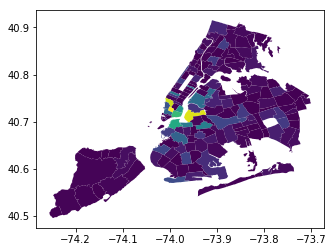

In [48]:
geodf.plot(column = 'mentions')

In [45]:
geodf.mentions = geodf.mentions.fillna(0)